# Deep learning, Neural Networks, and Reinforcement learning - Project Pennella Luca

# Self-Driving Cab in a Simple Environment

The major goal is to demonstrate how you can use RL techniques to develop an efficient and safe approach for tackling Self-Driving problem.

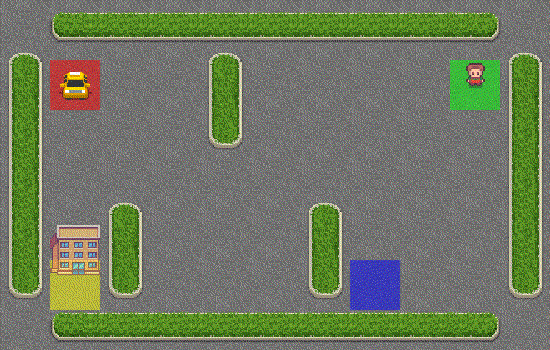

There are four locations in the grid indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

# Map:



```
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
```



# Actions

There are 6 discrete deterministic actions:

* **0:** move south
* **1:** move north
* **2:** move east
* **3:** move west
* **4:** pickup passenger
* **5:** drop off passenger

# Observations:

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

Note that there are 400 states that can actually be reached during an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.

Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination)

Passenger locations:

* **0:** R(ed)
* **1:** G(reen)
* **2:** Y(ellow)
* **3:** B(lue)
* **4:** in taxi

Destinations:
* **0:** R(ed)
* **1:** G(reen)
* **2:** Y(ellow)
* **3:** B(lue)

# Rewards
* -1 per step unless other reward is triggered.
* +20 delivering passenger.
* -10 executing “pickup” and “drop-off” actions illegally.

In [168]:
!pip install cmake gym[atari] scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [169]:
import matplotlib.pyplot as plt #Initializing environments
import gym
from IPython import display
from IPython.display import clear_output
import random
%matplotlib inline

In [170]:
env = gym.make('Taxi-v3')
env.reset()

203

In [171]:
env.render()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


* **env.reset**: Resets the environment and returns a random initial state.
* **env.step(action)**: Step the environment by one timestep. Returns
  * **observation**: Observations of the environment
  * **reward**: If your action was beneficial or not
  done: Indicates if we have successfully picked up and dropped off a passenger, also called one episode
  * **info**: Additional info such as performance and latency for debugging purposes
* **env.render**: Renders one frame of the environment (helpful in visualizing the environment)

* The **filled square** represents the taxi, which is yellow without a passenger and green with a passenger.
* The **pipe ("|")** represents a wall which the taxi cannot cross.
* **R, G, Y, B** are the possible pickup and destination locations. The **blue letter** represents the current passenger pick-up location, and the **purple letter** is the current destination.

In [172]:
env.reset()
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state) # Corresponding State 

env.s = state 
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



When the Taxi environment is created, there is an initial Reward table that's also created, called `P`. We can think of it like a matrix that has the number of states as rows and number of actions as columns.

In [173]:
env.P[328] # Reward Table

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

This dictionary has the structure `action: [(probability, nextstate, reward, done)]`.

* The 0-5 corresponds to the actions (south, north, east, west, pickup, dropoff) the taxi can perform at our current state in the illustration.
* In this env, probability is always 1.0.
* The nextstate is the state we would be in if we take the action at this index of the dict
* All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action (5)
* done is used to tell us when we have successfully dropped off a passenger in the right location. Each successfull dropoff is the end of an episode

# Solving the environment without Reinforcement Learning

We'll create an infinite loop which runs until one passenger reaches one destination (one episode), or in other words, when the received reward is 20.

In [174]:
env.s = 328  # set environment to illustration's state

Inizialize the variable for the cycles:

In [175]:
#Inizialize the variable for the cycles:
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation 

done = False 

In [176]:
while not done:
    action = env.action_space.sample() # method automatically selects one random
                                       # action from set of all possible actions
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 200
Penalties incurred: 66


In [177]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 200
State: 18
Action: 4
Reward: -1


Not good. Our agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. We can run this over and over, and it will never optimize. The agent has no memory of which action was best for each state, which is exactly what Reinforcement Learning will do for us.

# Reinforcement Learning

# Q-learning

In our Taxi environment, we have the reward table, P, that the agent will learn from. It does thing by looking receiving a reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial.

The values store in the Q-table are called a Q-values, and they map to a (state, action) combination.

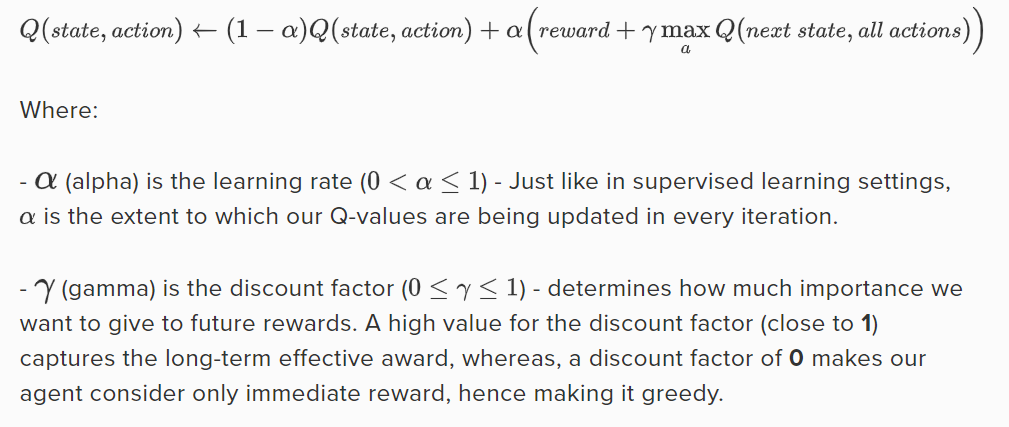

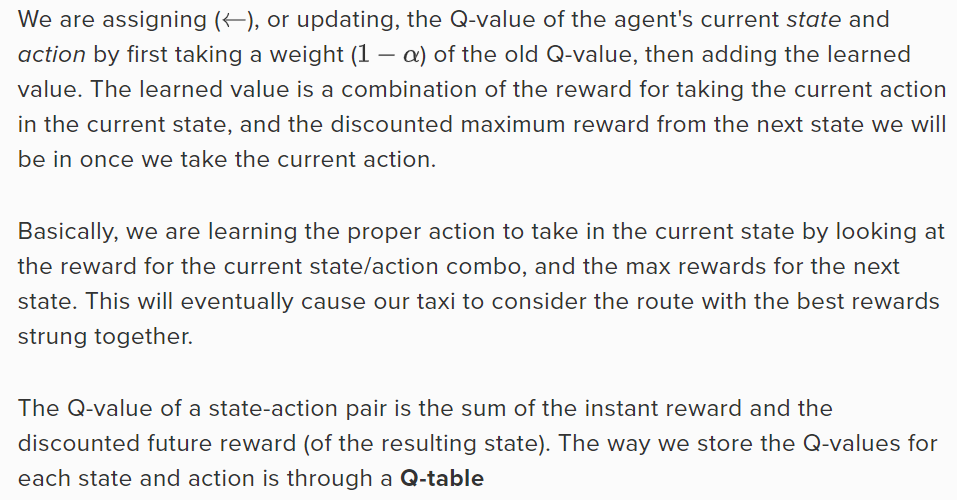

# Q-table

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training.

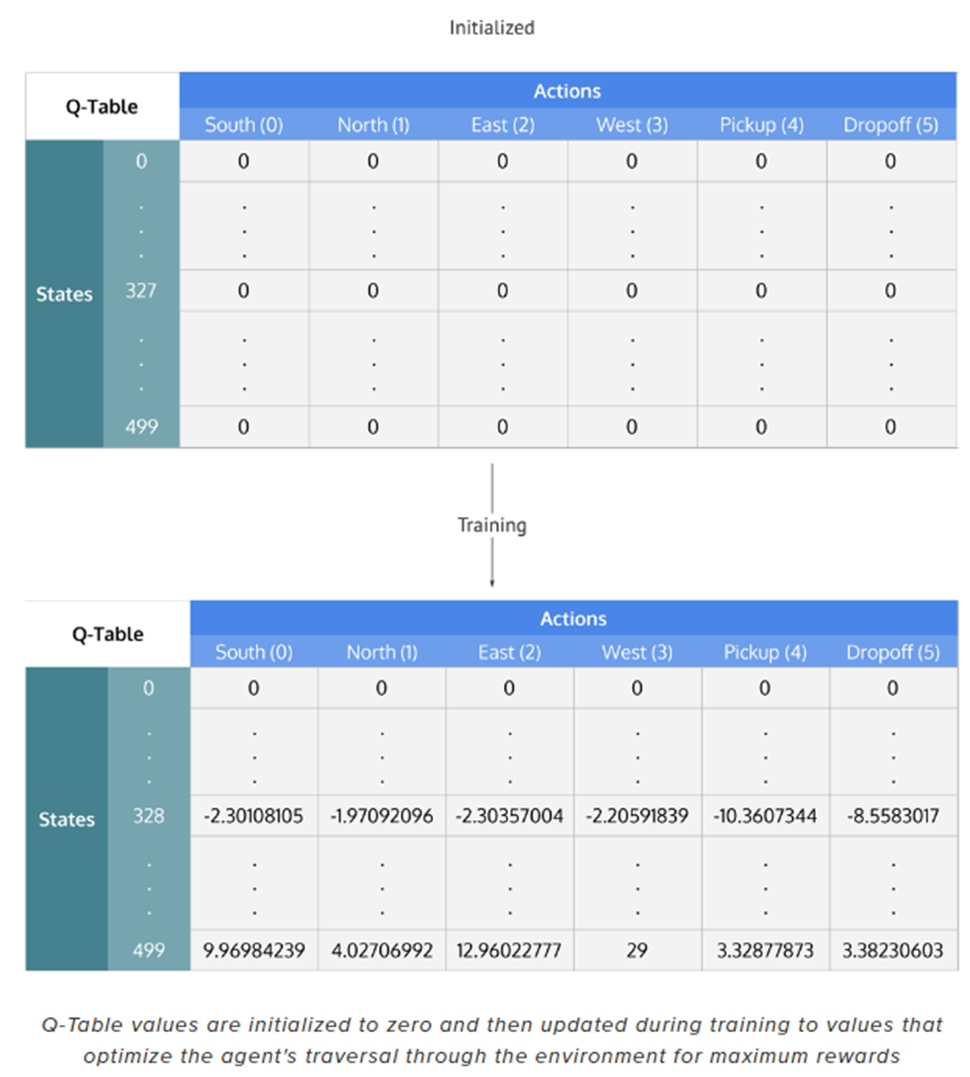

# Recap Q-Learning Process

* Initialize the Q-table by all zeros.
* Start exploring actions: For each state, select any one among all possible * actions for the current state (S).
* Travel to the next state (S') as a result of that action (a).
* For all possible actions from the state (S') select the one with the highest * Q-value.
* Update Q-table values using the equation.
* Set the next state as the current state.
* If goal state is reached, then end and repeat the process.

# Implementation

In [178]:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n]) # we'll initialize the Q-table to a 500*6 matrix of zeros

In [179]:
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

We can now create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In [180]:
# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []


In [181]:
# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005           # Exponential decay rate for exploration prob

In [182]:
%%time
"""Training the agent"""
from tqdm import tqdm

timesteps_per_episode = []
penalties_per_episode = []

for i in range(1, 10001):
    state = env.reset()
    epsilon = 0.1  
    #epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epochs)
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    # In the first part of while not done, we decide whether to pick a random action or to exploit the already computed Q-values.
    # This is done simply by using the epsilon value and comparing it to the random.uniform(0, 1) function, which returns an arbitrary number between 0 and 1.
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values
        
        # We execute the chosen action in the environment to obtain the next_state and the reward from performing the action.
        next_state, reward, done, info = env.step(action) 
        
        # We calculate the maximum Q-value for the actions corresponding to the next_state
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # We update our Q-value to the new_q_value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


Episode: 10000
Training finished.

CPU times: user 9.95 s, sys: 1.12 s, total: 11.1 s
Wall time: 11.8 s


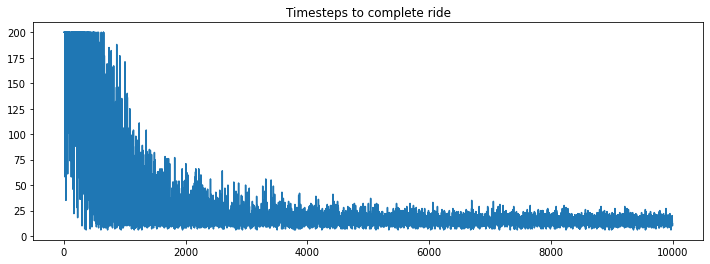

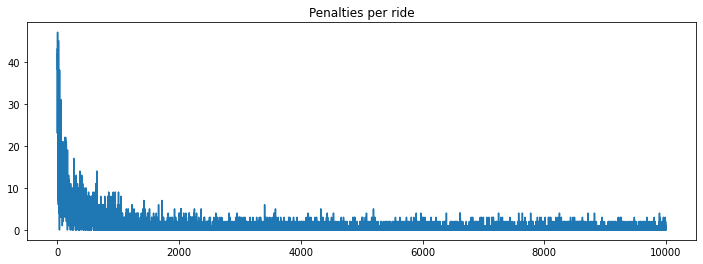

In [183]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

In [184]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 26.686
Avg penalties to complete ride: 0.9389


In [185]:
q_table

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-2.38273316, -2.35281272, -2.38823525, -2.33355016, -2.27325184,
        -9.7278556 ],
       [-1.83100028, -1.57327124, -1.86279031, -1.51429103, -0.7504    ,
        -9.64392317],
       ...,
       [-1.1958164 ,  0.3393399 , -1.15740814, -1.24471364, -1.96      ,
        -1.9172896 ],
       [-2.06572286, -2.06155366, -2.0671167 , -2.06029488, -5.01782068,
        -5.66262638],
       [ 0.84515477, -0.2014    ,  0.72734461, 10.94809633, -1.9114    ,
        -1.        ]])

The Q-table has been established over 100,000 episodes, let's see what the Q-values are at our illustration's state:

In [186]:
q_table[328]

array([-2.32901046, -2.27325278, -2.31022916, -2.31925084, -5.7268733 ,
       -5.17091827])

The max Q-value is "north" (-2.27).

# Evaluate agent's performance after Q-learning

In [190]:
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []
episode_rewards = []



for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    total_rewards_ep = 0
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = np.argmax(q_table[state])
        
        next_state, reward, done, info = env.step(action)

        
       
                      
        if reward == -10:
            penalties += 1
            
        total_rewards_ep += reward
        state = next_state
        epochs += 1
    episode_rewards.append(total_rewards_ep)    
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)


100%|██████████| 100/100 [00:00<00:00, 3136.16it/s]


In [195]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')
print(f'Avg reward to complete ride: {np.array(episode_rewards).mean()}')

Avg steps to complete ride: 19.16
Avg penalties to complete ride: 0.26
Avg reward to complete ride: -0.5


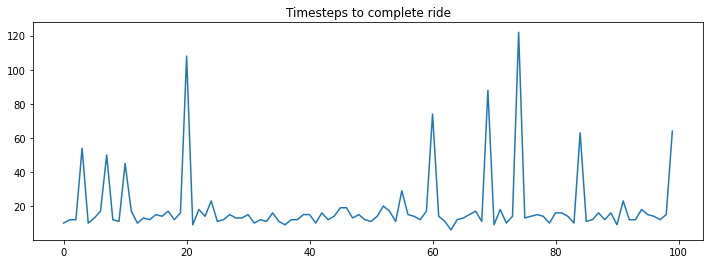

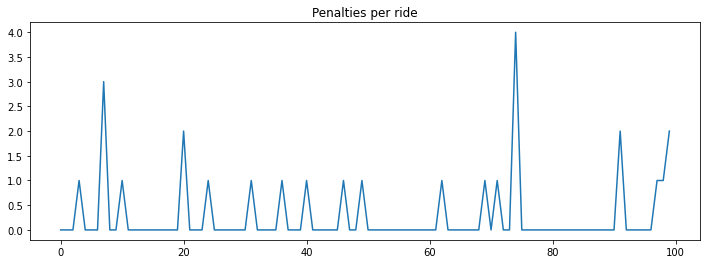

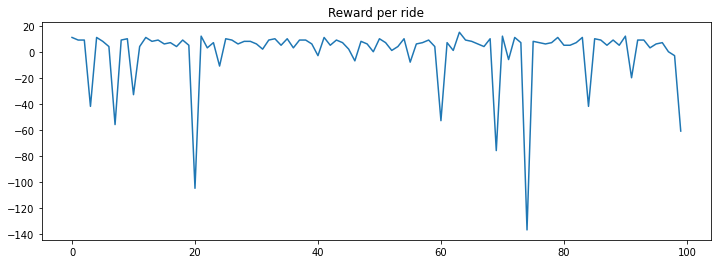

In [194]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Timesteps to complete ride")    
pd.Series(timesteps_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Penalties per ride")    
pd.Series(penalties_per_episode).plot(kind='line')
plt.show()

fig, ax = plt.subplots(figsize = (12, 4))
ax.set_title("Reward per ride")    
pd.Series(episode_rewards).plot(kind='line')
plt.show()

We can see from the evaluation, the agent's performance improved significantly and it incurred no penalties, which means it performed the correct pickup/dropoff actions with 100 different passengers.